train autoencoder WITHOUT using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os
from tensorflow.keras.models import load_model
import preprocess_functs as pp

2023-05-18 13:33:03.546449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 13:33:04.068903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load and split data

In [2]:
wireplane = "U"
np.random.seed(77)
path = '/home/vlian/Workspace/processed_ar39/'

In [3]:
dataset = np.load(path+'Sample_'+wireplane+'_Plane.npy', allow_pickle=True)

In [5]:
pp.group_num_labels_ar39

{0: 'adc_4_6',
 1: 'adc_7_9',
 2: 'adc_10_12',
 3: 'adc_13_15',
 4: 'adc_16_18',
 5: 'adc_19_21',
 6: 'adc_gt_21'}

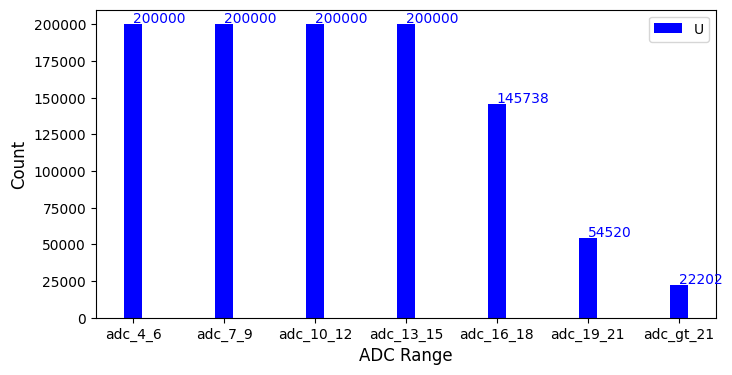

In [6]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels_ar39[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset[1], width=bar_width, color='blue', label=wireplane)

for i in range(7):
    dist = 1000
    plt.text(i, dataset[1][i] + dist, dataset[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

### get additonal samples for adc_gt_21 from NU_CC and NU_ES

In [8]:
path = '/home/vlian/Workspace/train_dune_lartpc_v2/'
nticks = 200
ADC_MIN = 15
signal_waveforms, clean_signal_waveforms = pp.process_data(wireplane=wireplane, path=path, ADC_MIN=ADC_MIN)

for i in range(10):
    signal_waveforms, clean_signal_waveforms = shuffle(signal_waveforms, clean_signal_waveforms)

nu_cc:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_cc/
nu_es:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_es/
noise:  /home/vlian/Workspace/train_dune_lartpc_v2/noise/

----------loading----------
--------data loaded!-------
---------------------------------
     signal+noise:  218916
     clean signal:  218916
     noise       :  100000
---------------------------------

filtering out small signals --> ADC > 15
     noise+signal :  (218916, 200)
     clean signal :  (218916, 200)
------------after filtering------------
     noise+signal :  (88644, 200)
     clean signal :  (88644, 200)


In [23]:
nu_es_cc_grouped_by_ADC = pp.adc_grouping(signal_waveforms, clean_signal_waveforms)
nu_es_cc_grouped_by_ADC = np.array(nu_es_cc_grouped_by_ADC, dtype=object)
for_combining = nu_es_cc_grouped_by_ADC[:, :7]

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       0

adc_6_9
count       0

adc_10_12
count       0

adc_13_15
count       0

adc_16_18
count       5250

adc_19_21
count       4573

adc_gt_21
count       78821

noise
count       0

     Total:    88644


In [24]:
print(dataset.shape, for_combining.shape)

(2, 7) (2, 7)


In [56]:
for i, wave in dataset[0]:
    wave.extend(for_combining[0][i])
    dataset[1][i] =+ for_combining[1][i]

IndexError: index 8 is out of bounds for axis 0 with size 7

In [53]:
a = [1, 3, 4, 5]
b = [34, 32, 453]

In [54]:
d = []
d = a.copy()
d.extend(b)

In [55]:
d

[1, 3, 4, 5, 34, 32, 453]

In [25]:
for i in for_combining[1]:
    print(i)

0
0
0
0
5250
4573
78821


In [19]:
waves_idx = 0
count_idx = 1
x_idx = 0
y_idx= 1

adc_group_idx = 0


In [22]:
dataset[waves_idx][adc_group_idx][x_idx][0]

array([  3,   3,   1,   2,  -1,  -1,  -1,   4,   5,   3,   3,  -1,   2,
         3,   2,   8,   2,   4,   9,   9,   8,   7,   2,  -4,  -7,  -6,
        -6,   0,   2,   5,   1,   2,  -3,  -3,  -7,  -7,  -3,  -3,   2,
         2,   5,   5,   6,   3,   2,   5,   2,   6,   9,   4,   4,   0,
        -5,  -7,   1,   2,   4,   6,   4,   4,  -2,  -3,   2,   4,   4,
         4,   1,  -6,  -9, -10,  -7,  -2,   0,   3,   1,   0,  -1,  -1,
         2,   1,   0,   0,  -1,  -2,   1,   1,   0,   1,   2,   1,   4,
         8,   8,   6,   2,  -5,  -6,  -4,   1,   6,   3,   2,   0,  -3,
        -1,   2,   4,   4,   2,   3,   3,   2,   2,   3,   4,  -3,  -3,
        -1,   3,   4,   2,  -2,  -2,  -1,  -4, -10, -10,  -6,  -4,  -3,
        -1,   0,  -2,  -1,  -2,   4,   5,   3,   3,  -2,  -5,  -7,  -7,
        -4,  -1,   3,   3,   4,   5,  -1,   1,   0,  -1,   0,   2,   2,
         1,   0,  -3,  -1,   3,   4,   1,   3,   2,   0,  -2,  -1,   0,
         5,   3,   6,   5,   5,  -1,   1,  -1,  -2,  -1,   0,   

In [21]:
type(dataset)

numpy.ndarray

In [ ]:
for idx in range(6,9):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization
#from keras import backend as K

In [ ]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1DTranspose

In [ ]:
time_periods = 200
autoencoder = Sequential()
# encoder
autoencoder.add(Conv1D(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu", input_shape=(time_periods,1)))
autoencoder.add(Conv1D(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))

# decoder
autoencoder.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu"))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, padding="same"))

autoencoder.compile(loss='mse', optimizer='adam')


In [ ]:
autoencoder.summary()

In [ ]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
batch_size_ = 2048

In [ ]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
            y_train_scaled,                                                            
            batch_size=batch_size_,                                              
            epochs=1000,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_scaled),                                                                      
            verbose=1)

In [ ]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [ ]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)   
plt.ylim(0, 0.1)                                                                 
plt.show()     

In [ ]:
#del x_train

import gc
gc.collect()

In [ ]:
#autoencoder.save('./models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')

In [ ]:
autoencoder = load_model('./models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')

In [ ]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

In [ ]:
autoencoder.evaluate(x_train_scaled, y_train_scaled, batch_size=4096)

In [ ]:
autoencoder.evaluate(x_valid_scaled, y_valid_scaled, batch_size=4096)

In [ ]:
#ae128 = load_model('./AE_models/model_AE_'+str(batch_size_)+'_mse' + wireplane + 'plane_nu.h5')

In [ ]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])



In [ ]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred = predictions*std + mean

In [ ]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [ ]:
pred_labels = [label_predictions(wave) for wave in pred]
truth_labels = [label_truths(t_wave) for t_wave in y_test_]

In [ ]:
cnn = load_model('../ROI_finder/ROI_models/model_'+wireplane+'plane_nu_ROI.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

In [ ]:
for i in range(100,200):
    if max(abs(y_test_[i])) < 20 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(10,4))
        plt.plot(x_test_[i], color='black', alpha=0.3, label='input')
        plt.plot(y_test_[i], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred[i], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels[i]))
        plt.title('CNN output: ' + str( round(cnn_pred[i], 3)))
        plt.legend()
        plt.show()


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(truth_labels, pred_labels, drop_intermediate=False)
roc_auc = auc(fpr, tpr)


In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='m', label='(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc="lower right")
plt.show()

In [ ]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
                    break
        wave_idx = index_


        axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        axes[i].plot(pred128[index_], color='m', label='model_128  ---   ' + str(pred_labels128[index_]))
        axes[i].plot(pred128_cmse[index_], color='green', label='model_128_cmse  ---   ' + str(pred_labels128_cmse[index_]))
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('./AE_TEST/pdfs/tmp_plts/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [ ]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = './AE_TEST/pdfs/tmp_plts/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./AE_TEST/pdfs/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [ ]:
make_complete_pdf(10, 0.94, 1)

In [ ]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_
